# Gold Forecating


## Libraries Importing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## File Reading

In [ ]:
data= pd.read_csv("GoldUP.csv")
data.head()

,Date,Gold_Price,Crude_Oil,Interest_Rate,USD_INR,Sensex,CPI,USD_Index
0,01-10-2000,4538,1455.51,8.0,46.318297,3711.02,37.23,116.65
1,01-11-2000,4483,1512.47,8.0,46.783613,3997.99,37.31,115.24
2,01-12-2000,4541,1178.11,8.0,46.745856,3972.12,36.98,109.56
3,01-01-2001,4466,1208.18,8.0,46.536033,4326.72,36.90,110.52
4,01-02-2001,4370,1267.18,7.5,46.514595,4247.04,36.73,112.01


In [ ]:
data.describe()

,Gold_Price,Crude_Oil,Interest_Rate,USD_INR,Sensex,CPI,USD_Index
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,19299.062762,3397.686318,6.715900,53.804819,18172.443891,73.372050,90.182510
std,11668.913490,1551.627401,1.188309,10.311144,11032.206600,29.106141,11.312607
min,4267.000000,887.420000,4.250000,39.366685,2811.600000,36.730000,71.800000
25%,6712.500000,2180.695000,6.000000,45.467395,8263.400000,45.190000,81.110000
50%,19056.000000,3303.550000,6.000000,48.664774,17464.810000,68.470000,88.940000
75%,29364.000000,4492.930000,7.000000,63.861030,26662.395000,101.370000,97.160000
max,52917.000000,6926.830000,10.250000,76.222334,41253.740000,129.300000,120.240000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239 entries, 0 to 238
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           239 non-null    object 
 1   Gold_Price     239 non-null    int64  
 2   Crude_Oil      239 non-null    float64
 3   Interest_Rate  239 non-null    float64
 4   USD_INR        239 non-null    float64
 5   Sensex         239 non-null    float64
 6   CPI            239 non-null    float64
 7   USD_Index      239 non-null    float64
dtypes: float64(6), int64(1), object(1)
memory usage: 15.1+ KB


## Data Preprocessing

In [ ]:
# Convert the Date column to datetime type
data['Date']=pd.to_datetime(data['Date'], format='%d-%m-%Y')
print(data.dtypes)

Date             datetime64[ns]
Gold_Price                int64
Crude_Oil               float64
Interest_Rate           float64
USD_INR                 float64
Sensex                  float64
CPI                     float64
USD_Index               float64
dtype: object


In [ ]:
# Setting the index to the Month and Year
data.set_index(['Date'], inplace=True)

In [ ]:
# Drop Unnecessary columns
data_ts=data[['Gold_Price']]

In [ ]:
print(data_ts.head())

            Gold_Price
Date                  
01-10-2000        4538
01-11-2000        4483
01-12-2000        4541
01-01-2001        4466
01-02-2001        4370


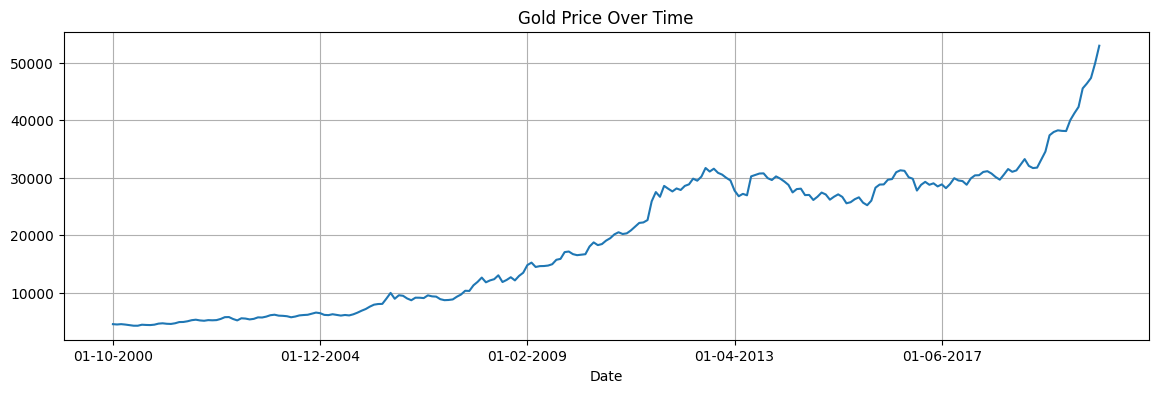

In [ ]:
data['Gold_Price'].plot(grid=True, figsize=(14, 4), title="Gold Price Over Time");

There is a clear upward trend in the Gold Price with  fluctuations suggesting volatility in price.

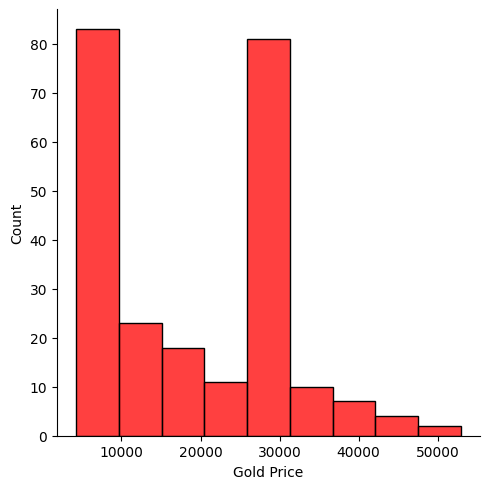

In [ ]:
sns.displot(data.Gold_Price, color='red')
plt.xlabel('Gold Price')
plt.show()

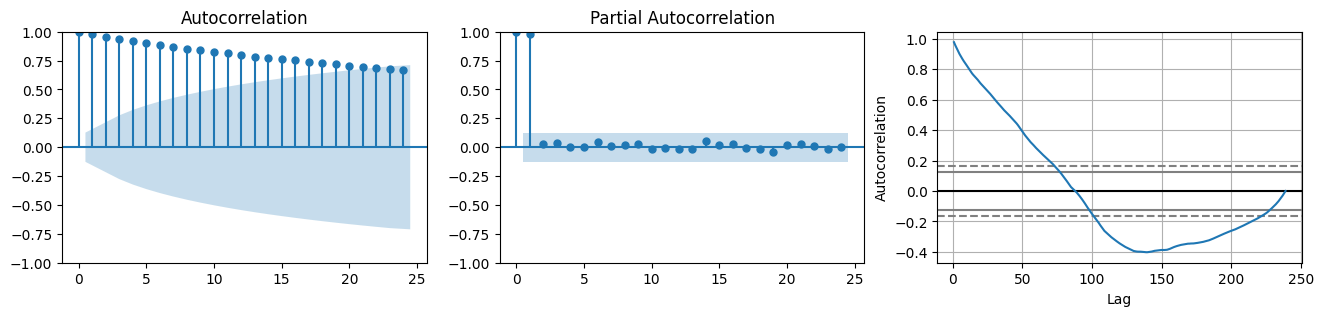

In [ ]:
# plotting correlation of Gold_Price
fig, ax = plt.subplots(1,3,figsize=(16,3))
plot_acf(data_ts.Gold_Price, ax=ax[0]);
plot_pacf(data_ts.Gold_Price, ax=ax[1]);
pd.plotting.autocorrelation_plot(data_ts.Gold_Price, ax=ax[2])
plt.show()

The ACF shows a slow decay, suggesting potential non-stationarity.

The PACF shows a sharp drop after the first lag, indicating that there is a significant correlation with the first lag, but subsequent lags do not contribute much additional information.
This behavior is often indicative of an AR (AutoRegressive) process, where only the immediate past value has a substantial relationship with the current value.

## Seasonal Decomposition


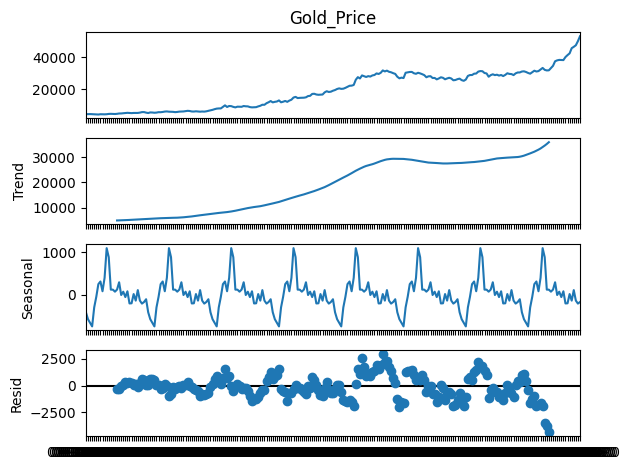

In [ ]:
# seasonal Decomposition
decomposition1 = seasonal_decompose(x=data_ts['Gold_Price'], model='additive', period=30)
decomposition1.plot()
plt.show()

1. **The Trend component** displays a consistent upward movement, indicating that the average price of gold has been increasing significantly over the period.
2. **The Seasonal component** shows regular patterns that repeat at consistent time intervals.
3. **The residuals** appear to be randomly scattered around zero, indicating that the model adequately captures the trend and seasonality. The variability seems constant over time, which is a good sign for modeling.
However, the presence of some clusters or patterns in the residuals could indicate potential areas for further investigation or refinement in modeling.

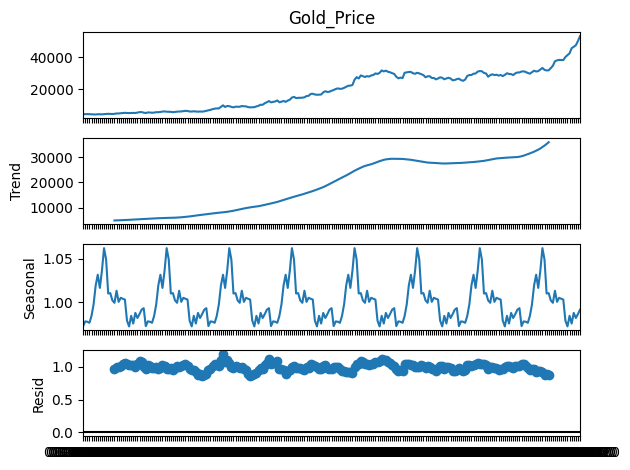

In [ ]:
# seasonal Decomposition
decomposition2 = seasonal_decompose(x=data_ts['Gold_Price'], model='multiplicative', period=30)
decomposition2.plot()
plt.show()

The residuals from the additive model seems to have a mean of approximately zeo, so it is preferred ovet the multiplicative one.

## Stationarity

ADF Statistic: 2.25
p-value: 0.999
Critical Values: ['1%: -3.46', '5%: -2.87', '10%: -2.57']



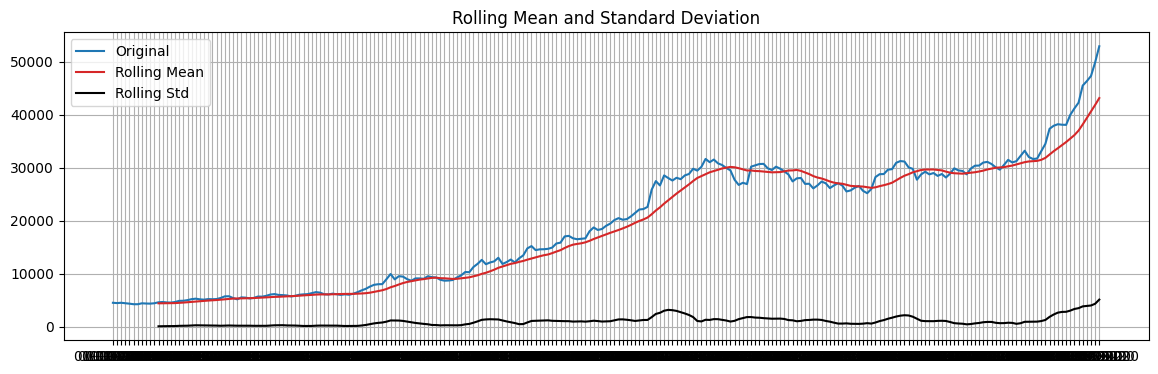

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")

    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid();

# run ADF on monthly temperatures
adftest(data_ts.Gold_Price)

p-value is very high; we fail to reject the null hypothesis H0: The Time Serie is not Sationary

## Seasonality

Dominant period: inf


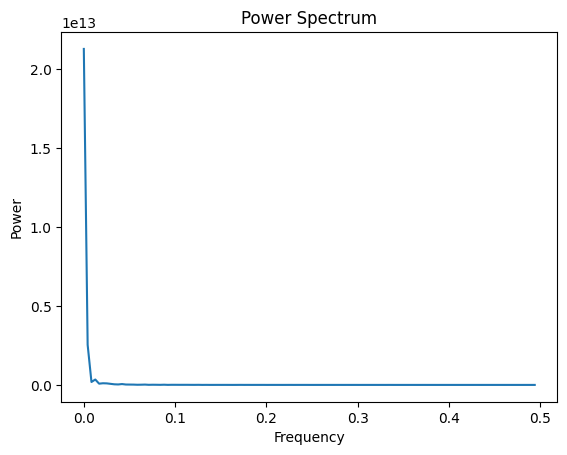

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def fft_analysis(signal):
    # Calculate the FFT
    fft_values = np.fft.fft(signal)

    # Calculate the frequencies
    frequencies = np.fft.fftfreq(len(signal))

    # Use only the positive frequencies (half of the FFT result)
    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_power_spectrum = np.abs(fft_values[:len(fft_values)//2])**2

    # Find the dominant frequency (excluding DC component)
    dominant_frequency = positive_frequencies[np.argmax(positive_power_spectrum)]

    # Calculate the dominant period
    dominant_period = 1 / dominant_frequency if dominant_frequency != 0 else np.inf

    return dominant_period, positive_frequencies, positive_power_spectrum

# Example usage
dominant_period, positive_frequencies, positive_power_spectrum = fft_analysis(data['Gold_Price'].values)
print(f"Dominant period: {np.round(dominant_period)}")

# Plot the power spectrum
plt.plot(positive_frequencies, positive_power_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Power Spectrum')
plt.show()


The Seasonality in this time series is overpowered by the trend in the data.

## Correlation with other variables

<Axes: xlabel='Date'>

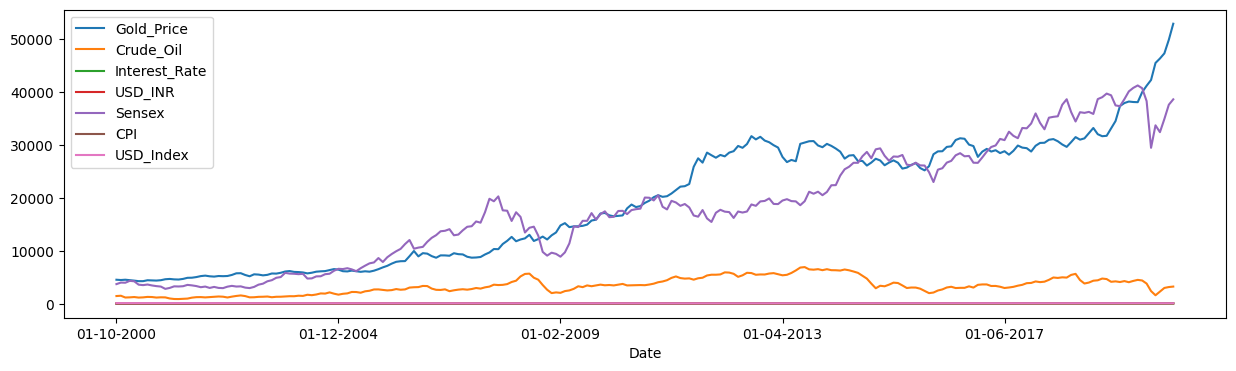

In [ ]:
data.plot(figsize=(15,4))

## Heat Map

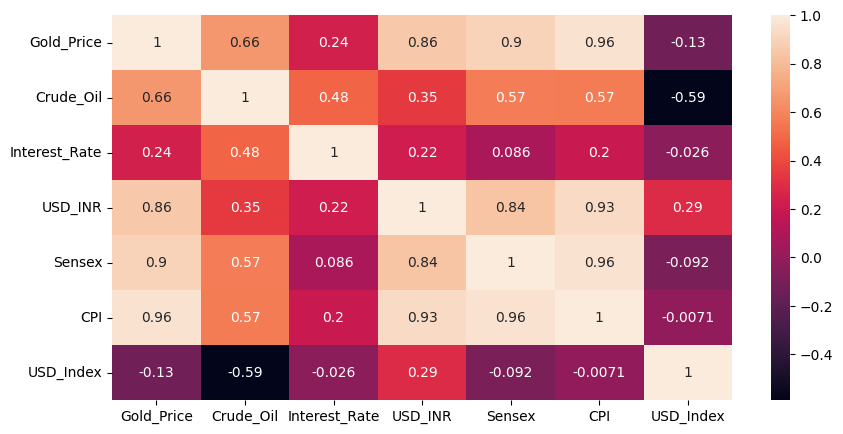

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(),annot=True)
plt.show()

In [ ]:
data_ts['Next Month Price'] = data_ts['Gold_Price'].shift(-1)
data_ts = data_ts.dropna()
data_ts.columns = ['Actual Price', 'Next Month Price']
data_ts['Actual Price'] = data_ts['Actual Price'].astype(float)
data_ts.head()

,Actual Price,Next Month Price
Date,,
01-10-2000,4538.0,4483.0
01-11-2000,4483.0,4541.0
01-12-2000,4541.0,4466.0
01-01-2001,4466.0,4370.0
01-02-2001,4370.0,4269.0


In [ ]:
data_ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238 entries, 01-10-2000 to 01-07-2020
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Actual Price      238 non-null    float64
 1   Next Month Price  238 non-null    float64
dtypes: float64(2)
memory usage: 5.6+ KB


## Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data_ts = pd.DataFrame(data=scaler.fit_transform(data_ts), columns=data_ts.columns, index=data_ts.index)
data_ts.head()

,Actual Price,Next Month Price
Date,,
01-10-2000,0.005942,0.004440
01-11-2000,0.004736,0.005632
01-12-2000,0.006007,0.004090
01-01-2001,0.004363,0.002117
01-02-2001,0.002258,0.000041


In [ ]:
# Dropping the 3 rows from 2000
data_ts=data_ts[3:]
data_ts.head()

,Actual Price,Next Month Price
Date,,
01-01-2001,0.004363,0.002117
01-02-2001,0.002258,0.000041
01-03-2001,0.000044,0.000000
01-04-2001,0.000000,0.003577
01-05-2001,0.003815,0.002734


##  Linear Regression Model

Linear Regression Results:
MAE: 0.02284807495647805
MSE: 0.0008643761947018568
MAPE: 0.031632339593166935


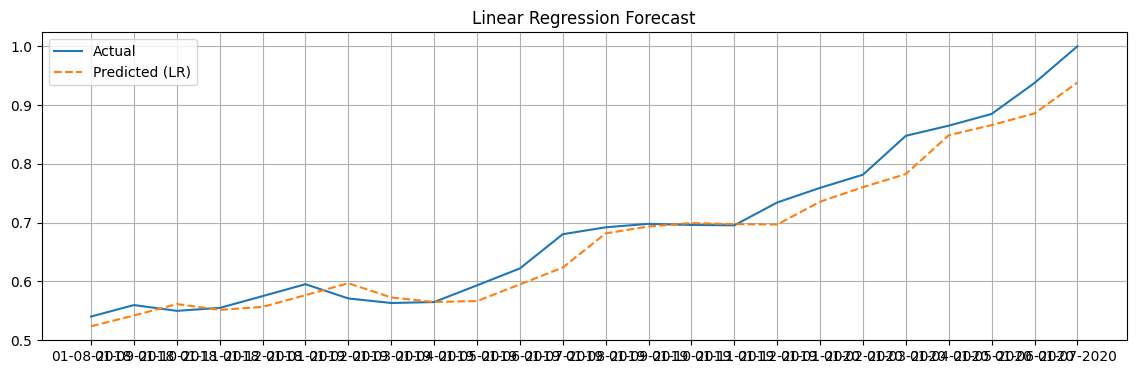

In [ ]:
## Splitting into Train and Test

# We'll use 90% of the data for training and the rest for testing
train_size = int(len(data_ts) * 0.9)
train, test = data_ts.iloc[:train_size], data_ts.iloc[train_size:]

# Linear Regression Model
from sklearn.linear_model import LinearRegression

X_train = train[['Actual Price']]
y_train = train['Next Month Price']
X_test = test[['Actual Price']]
y_test = test['Next Month Price']

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Linear Regression Evaluation
print("Linear Regression Results:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("MSE:", mean_squared_error(y_test, y_pred_lr))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_lr))

# Plotting predictions
plt.figure(figsize=(14, 4))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred_lr, label='Predicted (LR)', linestyle='--')
plt.title('Linear Regression Forecast')
plt.legend()
plt.grid(True)
plt.show()

**Result Interpretation:**
- The MSE (Mean Squared Error) is pretty low, which is a sign that the model is performing well overall.

- The MAPE (Mean Absolute Percentage Error) ~3.16%; this is a very intuitive and interpretable metric: predictions are, on average, 96.84% accurate


In [ ]:
import numpy as np

def fft_analysis(signal):
    # Calculate the FFT
    fft_values = np.fft.fft(signal)

    # Calculate the frequencies
    frequencies = np.fft.fftfreq(len(signal))

    # Calculate the power spectrum
    power_spectrum = np.abs(fft_values)**2

    # Find the dominant frequency (excluding DC component)
    dominant_frequency = frequencies[np.argmax(power_spectrum[1:]) + 1]

    # Calculate the dominant period
    dominant_period = 1 / dominant_frequency if dominant_frequency != 0 else np.inf

    return dominant_period, frequencies, power_spectrum

dominant_period, _, _ = fft_analysis(data['Gold_Price'].values)
print(f"Dominant period: {np.round(dominant_period)}")

Dominant period: 239.0


## ARIMA Model


### Model Building


ARIMA Results:
MAE: 5262.562554461592
MSE: 62079855.76292389
MAPE: 0.12208898064609067


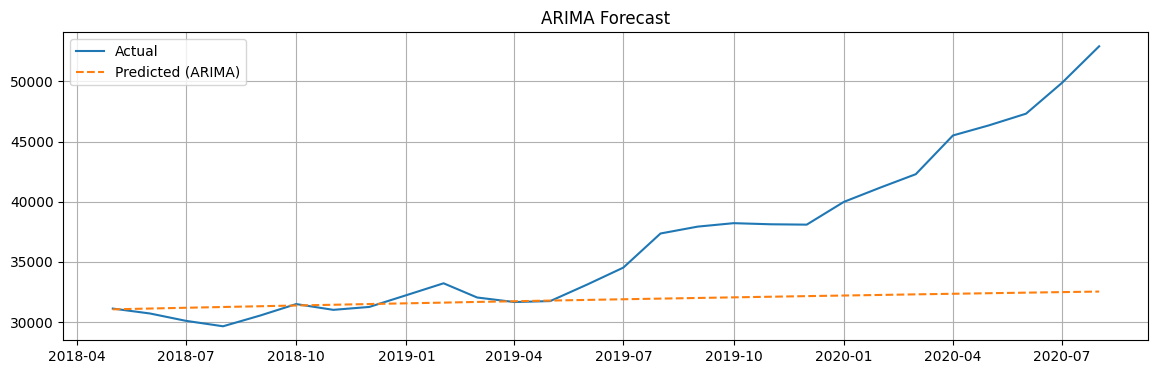

In [ ]:
## ARIMA Model

# Since ARIMA requires 1D input, we use only the 'Actual Price'
# We'll invert the scaling later for interpretability

# Inverse transformation for ARIMA modeling (work with real prices)
data_arima = pd.read_csv("GoldUP.csv")
data_arima['Date'] = pd.to_datetime(data_arima['Date'], format='%d-%m-%Y')
data_arima.set_index('Date', inplace=True)
gold_prices = data_arima['Gold_Price']

# Train-test split for ARIMA
train_arima = gold_prices.iloc[:train_size]
test_arima = gold_prices.iloc[train_size:]

# Fit ARIMA model (using simple parameters; we may tune them)
model_arima = ARIMA(train_arima, order=(1,1,1))
model_fit = model_arima.fit()

# Forecast
forecast_arima = model_fit.forecast(steps=len(test_arima))

# ARIMA Evaluation
print("\nARIMA Results:")
print("MAE:", mean_absolute_error(test_arima, forecast_arima))
print("MSE:", mean_squared_error(test_arima, forecast_arima))
print("MAPE:", mean_absolute_percentage_error(test_arima, forecast_arima))

# Plotting
plt.figure(figsize=(14, 4))
plt.plot(test_arima.index, test_arima, label='Actual')
plt.plot(test_arima.index, forecast_arima, label='Predicted (ARIMA)', linestyle='--')
plt.title('ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Model Tuning

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.8 MB/s eta 0:00:00


In [ ]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

best_score, best_order = float("inf"), None
for p in range(4):
    for d in range(2):  # usually 0 or 1
        for q in range(4):
            try:
                model = ARIMA(train_arima, order=(p,d,q))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_score:
                    best_score = aic
                    best_order = (p,d,q)
            except:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_score}")


Best ARIMA order: (3, 1, 3) with AIC: 3324.9226854944163


ARIMA Results:
MAE: 4685.336696607027
MSE: 49097057.83144492
MAPE: 0.10917972480233988


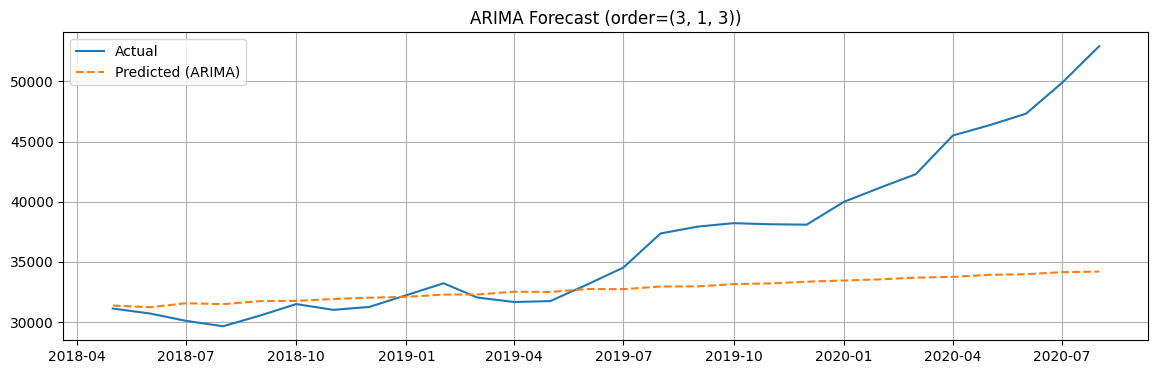

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
# Fit model
model = ARIMA(train_arima, order=(3, 1, 3))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test_arima))

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

print("ARIMA Results:")
print("MAE:", mean_absolute_error(test_arima, forecast))
print("MSE:", mean_squared_error(test_arima, forecast))
print("MAPE:", mean_absolute_percentage_error(test_arima, forecast))

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(test_arima.index, test_arima, label='Actual')
plt.plot(test_arima.index, forecast, label='Predicted (ARIMA)', linestyle='--')
plt.title(f'ARIMA Forecast (order={best_order})')
plt.legend()
plt.grid(True)
plt.show()
